### Wstęp do Uczenia Maszynowego 
##### Laboratorium 3

### 1. Kroswalidacja (*ang. cross validation*) vs Leave One Out

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

https://scikit-learn.org/stable/modules/cross_validation.html

### Zadanie 1
---------
Wymień zalety i wady kroswalidacji.


Zalety:
- dobrze działa w praktyce
- używamy wszystkich danych jako zbiór treningowy i testowy

Wady:
- zbiór treningowy i testowy nie są niezależne 
- możemy policzyć odchylenie standardowe, ale nie ma gwarancji na nie
- błąd jest obarczony błędem (bias) - próbki treningowe są mniejsze niż pełny zbiór
- wydłużenie czasu budowy, k razy trzeba trenowac modele

----------------------------------------------------------------------------------

In [15]:
# Import potrzebnych bibliotek i modułów.
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [16]:
# Wczytanie danych.
pima = pd.read_csv("../lab02/pima.csv")


In [17]:
# Definicja zbioru X i y.
y = pima.Outcome
X = pima.drop(["Outcome"], axis = 1)

#### Zadanie 2
--------
Używając funkcji `cross_val_score()` oszacuj wartość średnią oraz odchylenie standardowe 10-krotnej kroswalidacji dla modelu drzewa.

In [18]:
# Podział zbioru na próbkę treningową i testową.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
# Budowa modelu drzewa używając kroswalidacji na zbiorze treningowym.
Tree = tree.DecisionTreeClassifier()
scores = cross_val_score(Tree, X_train, y_train, cv = 10)

In [20]:
scores

array([0.68518519, 0.68518519, 0.62962963, 0.61111111, 0.81481481,
       0.68518519, 0.74074074, 0.60377358, 0.69811321, 0.75471698])

In [21]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.69 accuracy with a standard deviation of 0.06


### Zadanie 3
--------------------
Jaki jest stosunek obserwacji klasy 1 do klasy 0? Czy to powinno nas martwić? Czy możemy coś zrobić?

In [22]:
# Stosunek obserwacji klasy 1 do klasy 0.
y.sum()/(len(y) - y.sum())
# 0.536 = 1/2, czyli mamy ~66% klasy 0 i ~33% klasy 1
# W takim przypadku nie mamy się jeszcze czym martwić. 
# Gdyby ten stosunek był bardziej skrajny (np. 90% klasy 0 i 10% klasy 1) można wykorzystać bootstrap.

0.536

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score

### Zadanie 4
---------
Przeprowadź na zbiorze danych `pima.csv` 100 razy 10-krotną kroswalidację i przestaw otrzymane wyniki (miara `roc_auc`) - średnią oraz odchylenie standardowe. Narysuj rozkład otrzymanych wyników.



In [23]:
# Budowa drzewa.
Tree = tree.DecisionTreeClassifier()
scores_all = []
for i in range(0, 100):
    # Kroswalidacja 10-krotna (parametr "cv") z miarą roc_auc (parametr "scoring").
    scores = cross_val_score(Tree, X_train, y_train, cv = 10, scoring = 'roc_auc')
    scores_all.append(scores)


In [24]:
# Ramka danych tworzona z listy list.
df = pd.DataFrame(scores_all)

<Axes: >

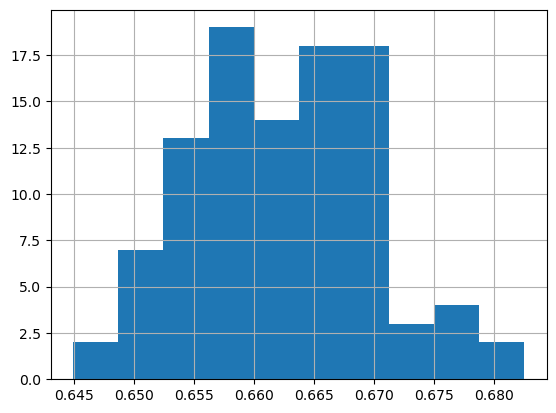

In [25]:
# Wyliczenie średniej i narysowanie histogramu.
df.aggregate(["mean", "std"], axis=1)["mean"].hist()

<Axes: >

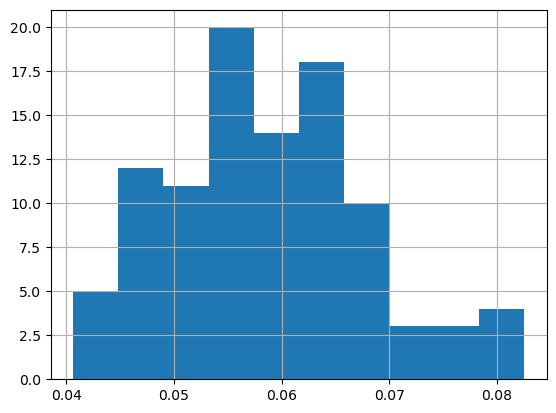

In [26]:
# Wyliczenie odchylenia standardowego i narysowanie histogramu.
df.aggregate(["mean", "std"], axis=1)["std"].hist()

### 2. Krzywa ROC

Jak się wylicza krzywą ROC?

1. Potrzebujemy wyliczyć FPR (false positive ratio) i TPR (true positive ratio) dla różnych rozważanych progów odcięcia.

$FPR = \frac{FP}{FP + TN}$

$TPR = \frac{TP}{TP + FN}$

2. Przykład

$y = [0, 0, 1, 1]$

$y_{pred} = [0.1, 0.35, 0.4, 0.8]$

$treshold = [\infty, 0.1, 0.35, 0.4, 0.8]$

### Zadanie 5
---------
Przygotuj model do oceny metodą `roc_auc`.


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [28]:
# Trzy różne modele drzewa.
Tree1 = tree.DecisionTreeClassifier()
Tree2 = tree.DecisionTreeClassifier(max_depth=3)
Tree3 = tree.DecisionTreeClassifier(max_leaf_nodes=5)

In [29]:
# Trening modeli.
Tree1 = Tree1.fit(X_train, y_train)
Tree2 = Tree2.fit(X_train, y_train)
Tree3 = Tree3.fit(X_train, y_train)

In [30]:
# Predykcja modeli.
pred1 = Tree1.predict_proba(X_test)
pred2 = Tree2.predict_proba(X_test)
pred3 = Tree3.predict_proba(X_test)

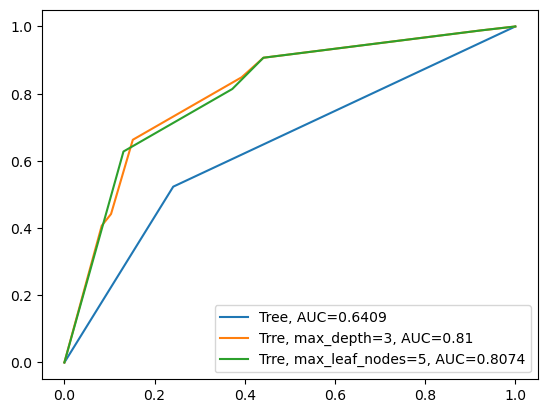

In [31]:
# Wyliczanie krzywej ROC dla 3 modeli.
fpr, tpr, thresholds = roc_curve(y_test, pred1[:,1])
plt.plot(fpr,tpr,label="Tree, AUC="+str(round(roc_auc_score(y_test, pred1[:,1]), 4)))
fpr, tpr, thresholds = roc_curve(y_test, pred2[:,1])
plt.plot(fpr,tpr,label="Trre, max_depth=3, AUC="+str(round(roc_auc_score(y_test, pred2[:,1]), 4)))
fpr, tpr, thresholds = roc_curve(y_test, pred3[:,1])
plt.plot(fpr,tpr,label="Trre, max_leaf_nodes=5, AUC="+str(round(roc_auc_score(y_test, pred3[:,1]), 4)))
plt.legend()

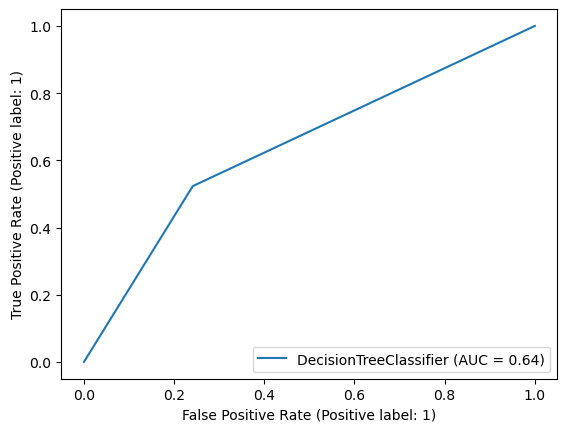

In [32]:
# Drugi sposób rysowanie krzywej ROC.
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(Tree1, X_test, y_test)

In [33]:
# Wyliczenia miary AUC.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, Tree1.predict_proba(X_test)[:, 1])

0.6409382518043304

### 4. Podsumowanie, czyli co warto wiedzieć...

1. Jak definiujemy problem klasyfikacji?
2. Podział zbioru na treningowy, walidacyjny i testowy.
2. Miary dokładności klasyfikatorów:

    a) macierz pomyłek (*ang. confusion matrix*),

    b) dokładność, czułość, precyzja, (*ang. accuracy, recall, precision*)

    c) krzywa ROC,

    d) AUC.


3. Kroswalidacja (*ang. cross validation*)
4. Drzewa decyzyjne:

    a) wady i zalety,

    b) jak budujemy drzewo,

    b) jakie mamy miary podziału,
    
    d) przycinanie drzew.